In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-23 02:17:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-23 02:17:10 (91.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
unzip_data("/content/drive/MyDrive/RiceImages/blue-original.zip")

In [ ]:
!rm -r /content/my_photo_classified/healthy_folder_blue
!rm -r /content/my_photo_classified/blast_folder_blue
!rm -r /content/my_photo_classified/brown_folder_blue

In [ ]:
walk_through_dir("/content/my_photo_classified")

There are 3 directories and 0 images in '/content/my_photo_classified'.
There are 0 directories and 765 images in '/content/my_photo_classified/brown_folder'.
There are 0 directories and 409 images in '/content/my_photo_classified/healthy_folder'.
There are 0 directories and 1494 images in '/content/my_photo_classified/blast_folder'.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
IMG_SIZE = (224, 224)
train_dir = '/content/my_photo_classified'

train_data, test_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                                validation_split=0.2,
                                                                                seed = 42,
                                                                                batch_size=32,
                                                                                subset="both")

Found 2668 files belonging to 3 classes.
Using 2135 files for training.
Using 533 files for validation.


In [ ]:
train_data.class_names

['blast_folder', 'brown_folder', 'healthy_folder']

In [ ]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam


# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(train_data.class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 pooling_layer (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
 softmax_float32 (Activation  (None, 3)                0         
 )                                                               
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-traina

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=8,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs","efficientnetb0_101_classes_all_data_feature_extract"),model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230523-021731
Epoch 1/8
67/67 [==============================] - 16s 128ms/step - loss: 0.8888 - accuracy: 0.6496 - val_loss: 0.5677 - val_accuracy: 0.7656
Epoch 2/8
67/67 [==============================] - 8s 114ms/step - loss: 0.5645 - accuracy: 0.7822 - val_loss: 0.4902 - val_accuracy: 0.8281
Epoch 3/8
67/67 [==============================] - 8s 115ms/step - loss: 0.4794 - accuracy: 0.8103 - val_loss: 0.4592 - val_accuracy: 0.8594
Epoch 4/8
67/67 [==============================] - 8s 117ms/step - loss: 0.4195 - accuracy: 0.8426 - val_loss: 0.4032 - val_accuracy: 0.9062
Epoch 5/8
67/67 [==============================] - 8s 114ms/step - loss: 0.3754 - accuracy: 0.8674 - val_loss: 0.3666 - val_accuracy: 0.9375
Epoch 6/8
67/67 [==============================] - 8s 113ms/step - loss: 0.3466 - accuracy: 0.8782 - val_loss: 0.3601 - val_accuracy: 0.9062
Epoch 7/8
67/67 [=====================

In [ ]:
result_model = model.evaluate(test_data)
result_model

17/17 [==============================] - 2s 111ms/step - loss: 0.4116 - accuracy: 0.8443


[0.4116393029689789, 0.8442776799201965]

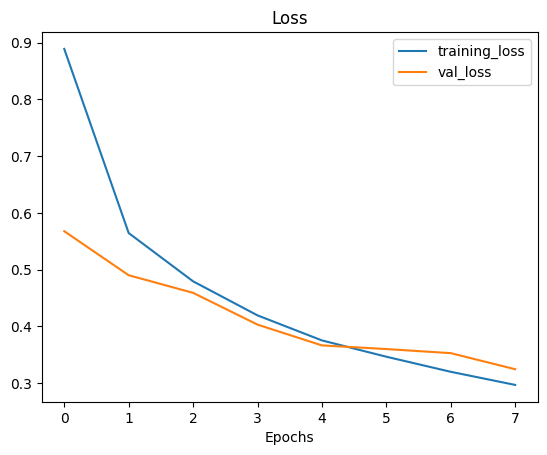

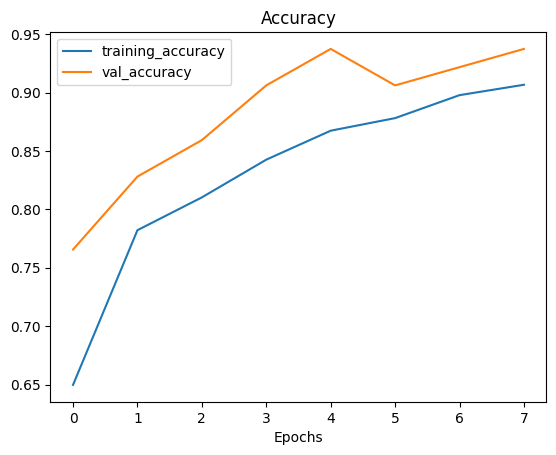

In [ ]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 8 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_101_food_classes_feature_extract.epoch[-1]) # start from previous last epoch

Epoch 8/8
67/67 [==============================] - 14s 137ms/step - loss: 0.3180 - accuracy: 0.8848 - val_loss: 0.3207 - val_accuracy: 0.9219


In [ ]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

17/17 [==============================] - 2s 97ms/step - loss: 0.3932 - accuracy: 0.8593


[0.39322900772094727, 0.8592870831489563]

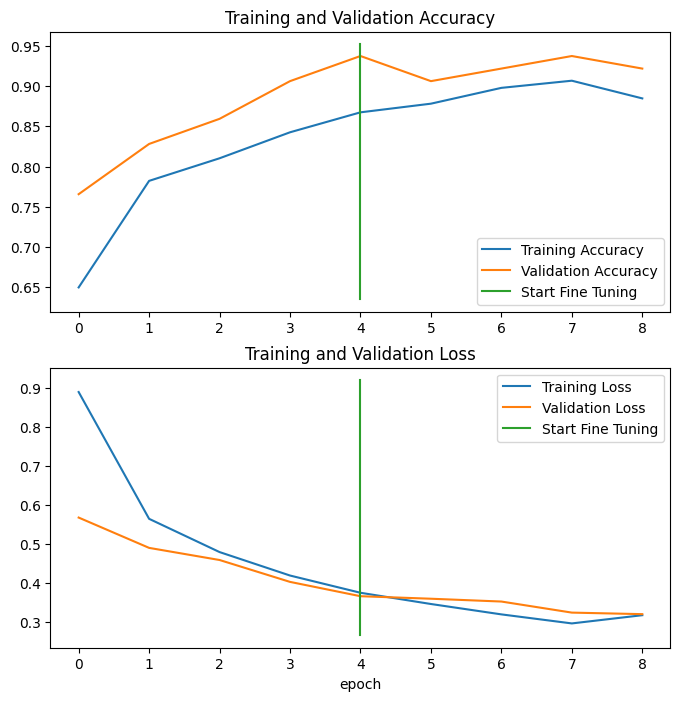

In [ ]:
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 1, 0, 0, 2, 1, 1, 0, 0, 0]

In [ ]:
class_names = test_data.class_names
class_names

['blast_folder', 'brown_folder', 'healthy_folder']

In [ ]:
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

17/17 [==============================] - 3s 114ms/step


In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 2, 0, 0, 2, 1, 1, 0, 0, 0])

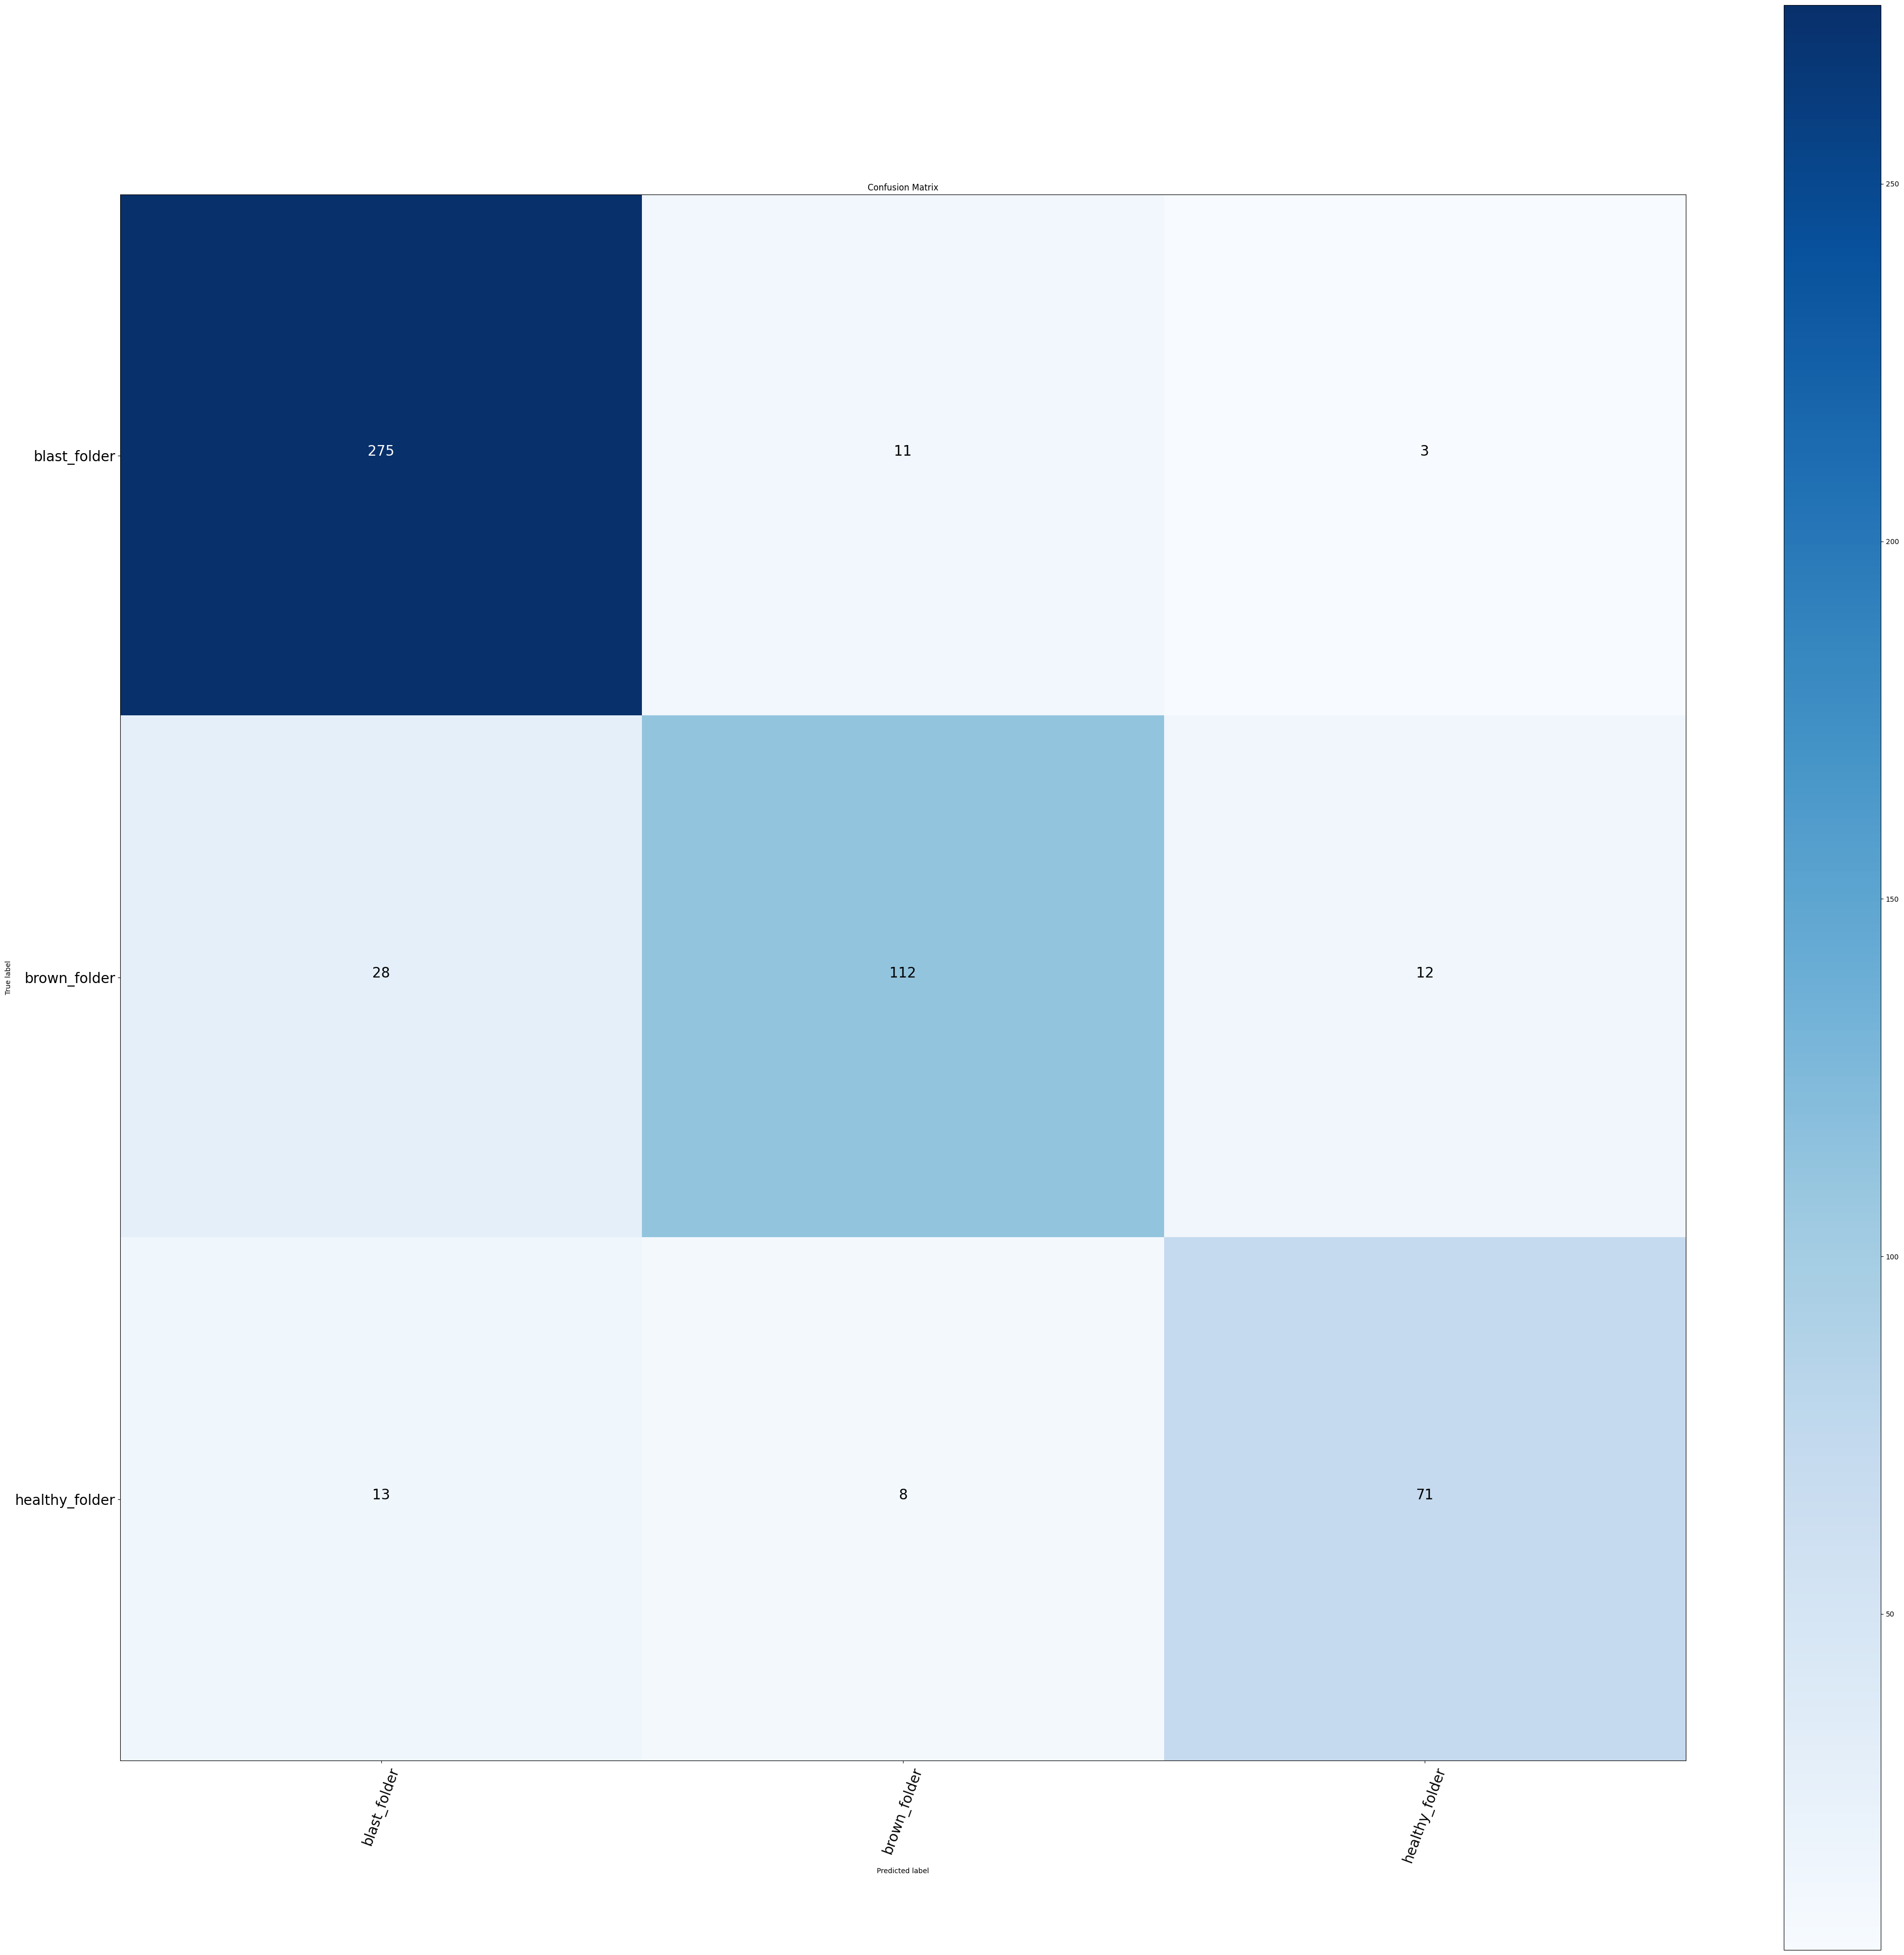

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       289
           1       0.85      0.74      0.79       152
           2       0.83      0.77      0.80        92

    accuracy                           0.86       533
   macro avg       0.85      0.82      0.83       533
weighted avg       0.86      0.86      0.86       533



In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.870253164556962,
  'recall': 0.9515570934256056,
  'f1-score': 0.9090909090909091,
  'support': 289},
 '1': {'precision': 0.8549618320610687,
  'recall': 0.7368421052631579,
  'f1-score': 0.7915194346289753,
  'support': 152},
 '2': {'precision': 0.8255813953488372,
  'recall': 0.7717391304347826,
  'f1-score': 0.797752808988764,
  'support': 92},
 'accuracy': 0.8592870544090057,
 'macro avg': {'precision': 0.850265463988956,
  'recall': 0.8200461097078486,
  'f1-score': 0.8327877175695494,
  'support': 533},
 'weighted avg': {'precision': 0.8581817099481003,
  'recall': 0.8592870544090057,
  'f1-score': 0.8563442499396683,
  'support': 533}}

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'blast_folder': 0.9090909090909091,
 'brown_folder': 0.7915194346289753,
 'healthy_folder': 0.797752808988764}

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
0,blast_folder,0.909091
2,healthy_folder,0.797753
1,brown_folder,0.791519


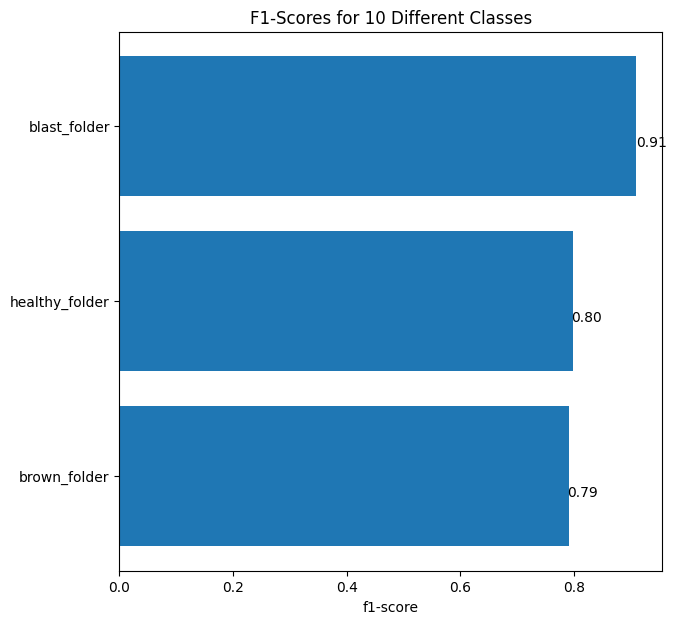

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
model.save('my_model')


In [ ]:
# Save your model in JSON format
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save your model's weights
model.save_weights("model_weights.h5")

In [ ]:
model.save("/content/drive/MyDrive/RiceImages/model.h5")
model.save("/content/model.h5")

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!tensorflowjs_converter --input_format=keras /content/model.h5 /content/drive/MyDrive/RiceImages/modelBin


2023-05-23 02:19:52.288474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
model.predict('/content/my_photo_classified/brown_folder/id_005sitfgr2.jpg.jpg')

IndexError: ignored